<a href="https://colab.research.google.com/github/a-chlibi/anomaly_detection/blob/dev/anomaly_Detection_Preview_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# --- CONFIG ---
CSV_FILE = "Nakamura2.csv"
SIGNAL_COLUMN = "Nakamura 2 [A]"
TIME_COLUMN = "Unix timestamp [s]"
DATETIME_COLUMN = "Date & Time"
MINIMUM_DISTANCE = 10  # Minimum distance between peaks in samples
THRESHOLD_METHOD = "std"  # Choose: "std", "percentile", "baseline"
FACTOR = 2.0      # For std method
PERCENTILE = 95   # For percentile method
DELTA = 1.5       # For baseline method


# Data Preprocesssing


*   Upload the file
*   Vizualise the data
*   Choose the segment that has no abnormalities for the training set
*   Duplicate the segment the normal data  



In [44]:
## Upload the file
import numpy as np
import pandas as pd
import plotly.graph_objs as go

df = pd.read_csv(CSV_FILE)

##Vizualise the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[DATETIME_COLUMN], y=df[SIGNAL_COLUMN]))
fig.update_layout(
    title="Original Signal (Zoomable)",
    xaxis_title="Date & Time",
    yaxis_title="Current [A]",
    template="plotly_white",
    height=500
)

fig.show()


###Observation :
The normal data according to the graph is from ***4/25/2025 7:05:02AM*** to ***4/25/2025 7:15:50AM***
###Work Plan:
Choose that segment and duplicate it to continue the rest of the work with it

In [45]:
## Choose the data from 4/25/2025 7:05:02AM to 4/25/2025 7:15:50AM
# Convert 'Date & Time' column to datetime objects
df['Date & Time'] = pd.to_datetime(df['Date & Time'])

# Filter the data
df_segment = df[(df['Date & Time'] >= pd.to_datetime('2025-04-25 07:05:02')) & (df['Date & Time'] <= pd.to_datetime('2025-04-25 07:15:50'))]

# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_segment[DATETIME_COLUMN], y=df_segment[SIGNAL_COLUMN]))
fig.update_layout(
    title="Choosen Segment (Zoomable)",
    xaxis_title="Date & Time",
    yaxis_title="Current [A]",
    template="plotly_white",
    height=500
)
fig.show()

In [46]:
## Create a data set with duplication of the segment for almost 24hours
df_duplicated = pd.concat([df_segment] * int((24*60*60)/len(df_segment)), ignore_index=True)

In [47]:
df_duplicated

,Unix timestamp [s],Date & Time,Nakamura 2 [A]
0,1745561102,2025-04-25 07:05:02,1.900
1,1745561108,2025-04-25 07:05:08,1.891
2,1745561114,2025-04-25 07:05:14,2.001
3,1745561120,2025-04-25 07:05:20,2.041
4,1745561126,2025-04-25 07:05:26,5.240
...,...,...,...
86323,1745561726,2025-04-25 07:15:26,1.902
86324,1745561732,2025-04-25 07:15:32,1.892
86325,1745561738,2025-04-25 07:15:38,1.982
86326,1745561744,2025-04-25 07:15:44,2.020


In [48]:
# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(y=df_duplicated[SIGNAL_COLUMN].iloc[:1200]))
fig.update_layout(
    title="Duplicated Normal Segment (Zoomable)",
    yaxis_title="Current [A]",
    template="plotly_white",
    height=500
)
fig.show()


# Data Preperation
In this section, we'll be going forward with the data we have choosen and duplicated.  
We'll create new attributes (features) that will help us understand our data on a deeper level and contribute to the next step: **Modeling** \
Our feature extraction will be in two steps:


*   Statistical features
*   Frequency domain features



## 1. Feature Extraction
### a. Statistical Features
  operate in the original/time domain, capture amplitude distribution

In [49]:
## Remove the unix timestamp and date and time columns and rename the Nakamura 2 [A] column to Amplitude
data = df_duplicated.drop(columns=[TIME_COLUMN, DATETIME_COLUMN])
data = data.rename(columns={SIGNAL_COLUMN: "Amplitude"})
## Information about the dataframe
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86328 entries, 0 to 86327
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Amplitude  86328 non-null  float64
dtypes: float64(1)
memory usage: 674.6 KB


,Amplitude
count,86328.000000
mean,6.776431
std,5.238077
min,1.800000
25%,3.794000
50%,4.302000
75%,8.361000
max,21.261000


In [50]:
def extract_dynamic_window_statistical_features(data, min_window=10, max_window=200,
                                    adaptivity_factor=0.8, adaptivity_measure='std'):
    """
    Extract statistical features using dynamically sized windows.

    Parameters:
    - data: Time series data (numpy array or list)
    - min_window: Minimum window size
    - max_window: Maximum window size
    - adaptivity_factor: How strongly window size responds to data changes (0-1)
    - adaptivity_measure: Method to determine window size ('std', 'iqr', 'entropy')

    Returns:
    - Dictionary of feature arrays
    """
    import numpy as np
    from scipy import stats

    features = {
        'window_size': [],
        'mean': [],
        'median': [],
        'std': [],
        'iqr': [],
        'skew': [],
        'kurtosis': [],
        'range': [],
        'mad': [],  # Median Absolute Deviation
        'energy': [],
        'rms': [],  # Root Mean Square
        'peak_to_avg': [],
        'crest_factor': [],
        'zero_crossings': [],
        'mean_crossing_rate': [],
        'entropy': [],
        'trend': [],
        'seasonality': [],
        'local_variation': []
    }

    for i in range(len(data)):
        # For very beginning of series, use fixed window
        if i < min_window:
            window_size = min_window
        else:
            # Calculate local characteristic to determine window size
            recent_data = data[max(0, i-max_window):i]

            if adaptivity_measure == 'std':
                local_characteristic = np.std(recent_data)
                # Normalize by mean if possible
                if np.mean(recent_data) != 0:
                    local_characteristic /= abs(np.mean(recent_data))

            elif adaptivity_measure == 'iqr':
                q75, q25 = np.percentile(recent_data, [75, 25])
                local_characteristic = (q75 - q25)
                # Normalize by median if possible
                if np.median(recent_data) != 0:
                    local_characteristic /= abs(np.median(recent_data))

            elif adaptivity_measure == 'entropy':
                # Approximate entropy using histogram
                hist, _ = np.histogram(recent_data, bins='auto')
                hist = hist / np.sum(hist)
                local_characteristic = -np.sum(hist * np.log2(hist + 1e-10))
                # Normalize to 0-1 range approximately
                local_characteristic = local_characteristic / np.log2(len(hist) + 1e-10)

            # Limit the local characteristic to 0-1 range
            local_characteristic = min(1.0, max(0.0, local_characteristic))

            # Calculate window size - smaller when local characteristic is higher
            window_size = min_window + (max_window - min_window) * (1 - (adaptivity_factor * local_characteristic)**2)
            window_size = max(min_window, min(max_window, window_size))

        # Get window data
        window_size = int(window_size)

        window_data = data[max(0, i-window_size):i+1]

        if len(window_data) <= 1:  # Skip if not enough data
            continue

        # Basic statistics
        features['window_size'].append(window_size)
        features['mean'].append(np.mean(window_data))
        features['median'].append(np.median(window_data))
        features['std'].append(np.std(window_data))

        # Interquartile range
        q75, q25 = np.percentile(window_data, [75, 25])
        features['iqr'].append(q75 - q25)

        # Distribution shape
        features['skew'].append(stats.skew(window_data))
        features['kurtosis'].append(stats.kurtosis(window_data))
        features['range'].append(np.max(window_data) - np.min(window_data))

        # Robust statistics
        features['mad'].append(np.median(np.abs(window_data - np.median(window_data))))

        # Signal energy features
        features['energy'].append(np.sum(window_data**2) / len(window_data))
        features['rms'].append(np.sqrt(np.mean(window_data**2)))

        # Peak features
        if np.mean(np.abs(window_data)) > 0:
            features['peak_to_avg'].append(np.max(np.abs(window_data)) / np.mean(np.abs(window_data)))
        else:
            features['peak_to_avg'].append(0)

        if features['rms'][-1] > 0:
            features['crest_factor'].append(np.max(np.abs(window_data)) / features['rms'][-1])
        else:
            features['crest_factor'].append(0)

        # Crossing features
        zero_crossings = np.sum(np.diff(np.signbit(window_data)))
        features['zero_crossings'].append(zero_crossings / len(window_data))

        mean_crossings = np.sum(np.diff(np.signbit(window_data - np.mean(window_data))))
        features['mean_crossing_rate'].append(mean_crossings / len(window_data))

        # Information theory
        hist, _ = np.histogram(window_data, bins='auto')
        hist = hist / np.sum(hist)
        features['entropy'].append(-np.sum(hist * np.log2(hist + 1e-10)))

        # Trend and seasonality approximation
        if len(window_data) >= 3:
            # Simple linear trend coefficient
            x = np.arange(len(window_data))
            try:
                slope, _, _, _, _ = stats.linregress(x, window_data)
                features['trend'].append(slope)
            except:
                features['trend'].append(0)

            # Crude seasonality estimate using autocorrelation at lag 1
            if len(window_data) >= 4:
                acf = np.correlate(window_data - np.mean(window_data),
                                  window_data - np.mean(window_data), mode='full')
                acf = acf[len(acf)//2:] / np.var(window_data) / len(window_data)
                features['seasonality'].append(acf[1] if len(acf) > 1 else 0)
            else:
                features['seasonality'].append(0)
        else:
            features['trend'].append(0)
            features['seasonality'].append(0)

        # Local variation - ratio of sequential differences to overall variation
        if len(window_data) >= 2 and np.std(window_data) > 0:
            local_var = np.mean(np.abs(np.diff(window_data))) / np.std(window_data)
            features['local_variation'].append(local_var)
        else:
            features['local_variation'].append(0)
    # Convert the features dictionary to a DataFrame
    features_df = pd.DataFrame(features)

    return features_df

In [51]:
statistical_features = extract_dynamic_window_statistical_features(data['Amplitude'], min_window=10, max_window=200)


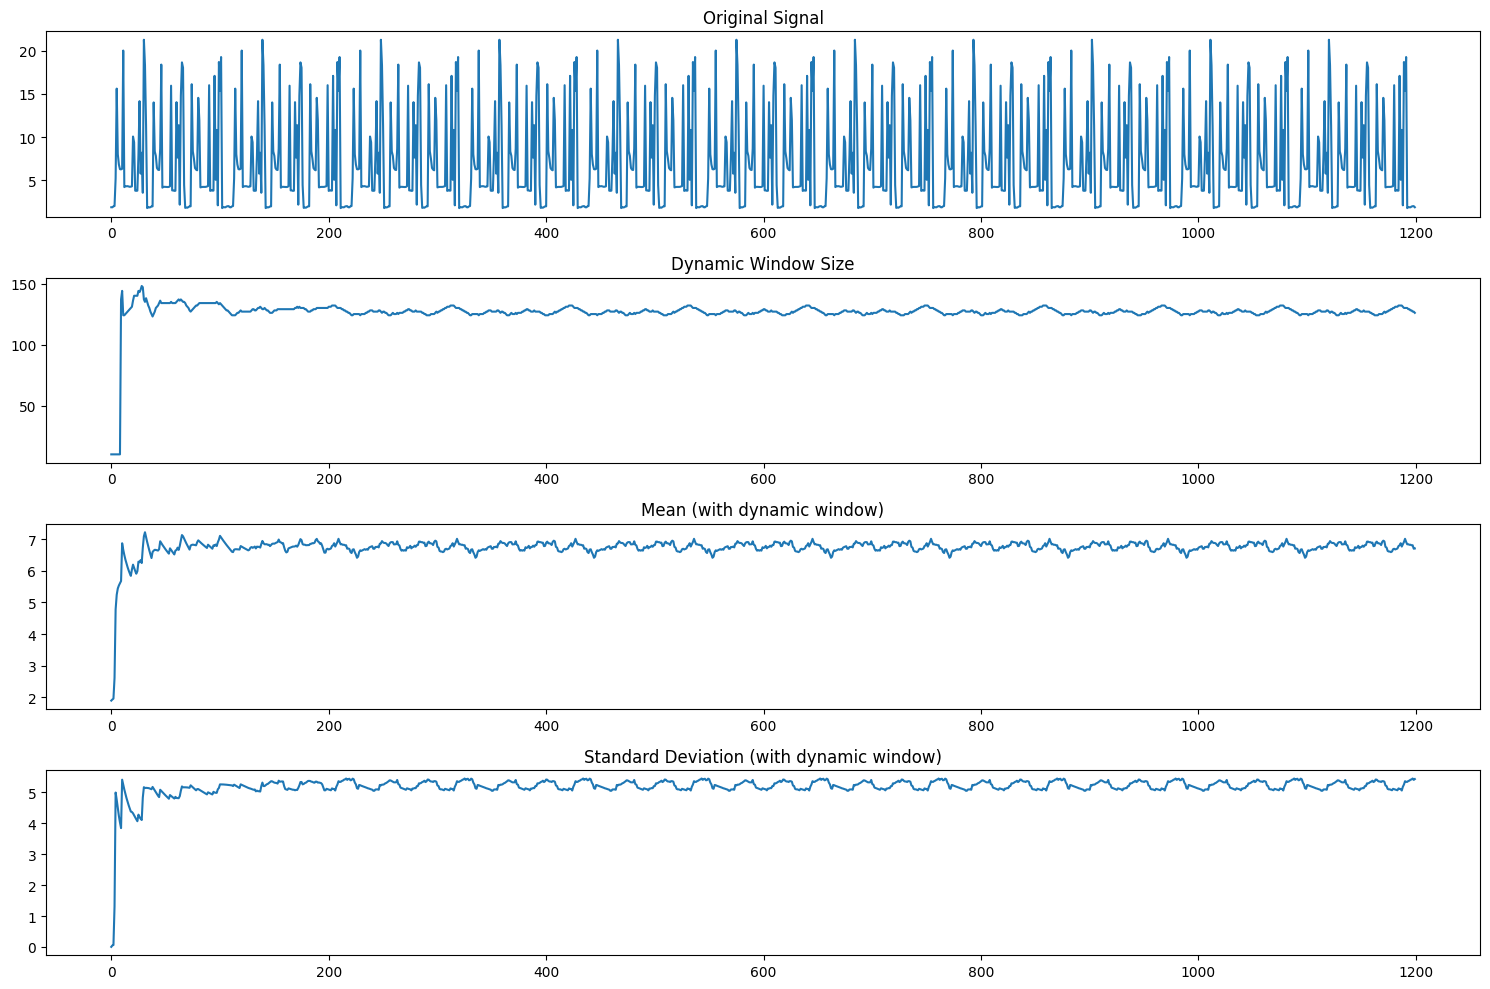

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86327 entries, 0 to 86326
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   window_size         86327 non-null  int64  
 1   mean                86327 non-null  float64
 2   median              86327 non-null  float64
 3   std                 86327 non-null  float64
 4   iqr                 86327 non-null  float64
 5   skew                86327 non-null  float64
 6   kurtosis            86327 non-null  float64
 7   range               86327 non-null  float64
 8   mad                 86327 non-null  float64
 9   energy              86327 non-null  float64
 10  rms                 86327 non-null  float64
 11  peak_to_avg         86327 non-null  float64
 12  crest_factor        86327 non-null  float64
 13  zero_crossings      86327 non-null  float64
 14  mean_crossing_rate  86327 non-null  float64
 15  entropy             86327 non-null  float64
 16  tren

In [52]:
import matplotlib.pyplot as plt

# Plot example features
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(data['Amplitude'].iloc[:1200])
plt.title('Original Signal')

plt.subplot(4, 1, 2)
plt.plot(statistical_features['window_size'].iloc[:1200])
plt.title('Dynamic Window Size')

plt.subplot(4, 1, 3)
plt.plot(statistical_features['mean'].iloc[:1200])
plt.title('Mean (with dynamic window)')

plt.subplot(4, 1, 4)
plt.plot(statistical_features['std'].iloc[:1200])
plt.title('Standard Deviation (with dynamic window)')

plt.tight_layout()
plt.show()
statistical_features.head()
statistical_features.describe()
statistical_features.info()

In [53]:
##Combine the original data with the features we extracted
features_df = statistical_features.drop(columns=['window_size'])
data= pd.concat([data, features_df], axis=1)
data.head()

,Amplitude,mean,median,std,iqr,skew,kurtosis,range,mad,energy,rms,peak_to_avg,crest_factor,zero_crossings,mean_crossing_rate,entropy,trend,seasonality,local_variation
0,1.900,1.895500,1.8955,0.004500,0.00450,0.000000,-2.000000,0.009,0.0045,3.592941,1.895505,1.002374,1.002371,0.0,0.500000,1.000000,0.000000,0.000000,2.000000
1,1.891,1.930667,1.9000,0.049869,0.05500,0.689873,-1.500000,0.110,0.0090,3.729961,1.931311,1.036430,1.036084,0.0,0.333333,0.918296,0.050500,0.000000,1.193133
2,2.001,1.958250,1.9505,0.064403,0.11325,0.133812,-1.805527,0.150,0.0550,3.838891,1.959309,1.042257,1.041694,0.0,0.250000,1.000000,0.053300,0.276054,0.822949
3,2.041,2.614600,2.0010,1.313963,0.14100,1.492810,0.240377,3.349,0.1010,8.562633,2.926198,2.004131,1.790720,0.0,0.200000,0.721928,0.683000,-0.022344,0.638907
4,5.240,4.780833,2.0210,4.990149,2.51500,1.583550,0.767563,13.721,0.1255,47.757951,6.910713,3.265539,2.259101,0.0,0.166667,1.251629,2.247057,0.185329,0.550284


###b. Frequency Domain Features
periodic patterns and components that may not be evident in the time domain

In [54]:
def extract_frequency_domain_features(data, min_window=10, max_window=200,
                                 adaptivity_factor=0.8, adaptivity_measure='std',
                                 sampling_rate=1.0):
    """
    Extract frequency domain features using dynamically sized windows.

    Parameters:
    - data: Time series data (numpy array or list)
    - min_window: Minimum window size
    - max_window: Maximum window size
    - adaptivity_factor: How strongly window size responds to data changes (0-1)
    - adaptivity_measure: Method to determine window size ('std', 'iqr', 'entropy')
    - sampling_rate: Sampling rate of the time series data (Hz)

    Returns:
    - Dictionary of frequency domain feature arrays
    """
    import numpy as np
    from scipy import stats, signal
    import pandas as pd

    features = {
        'window_size': [],
        # Spectral density features
        'dominant_freq': [],        # Frequency with highest power
        'dominant_freq_power': [],  # Power at dominant frequency
        'spectral_centroid': [],    # Center of mass of the spectrum
        'spectral_bandwidth': [],   # Width of the spectrum
        'spectral_flatness': [],    # Flatness of the spectrum (Wiener entropy)
        'spectral_roll_off': [],    # Frequency below which 85% of power is contained
        'spectral_crest': [],       # Ratio of max power to mean power
        'spectral_slope': [],       # Linear regression slope of spectrum
        'spectral_kurtosis': [],    # Kurtosis of the spectrum
        'spectral_skewness': [],    # Skewness of the spectrum
        # Band power features
        'low_freq_power': [],       # Power in low frequency band
        'mid_freq_power': [],       # Power in mid frequency band
        'high_freq_power': [],      # Power in high frequency band
        'low_high_ratio': [],       # Ratio of low to high frequency power
        # Harmonic features
        'harmonic_ratio': [],       # Ratio of harmonic power to total power
        'fundamental_freq': [],     # Estimated fundamental frequency
        # Wavelet features
        'wavelet_energy_ratio': [], # Ratio of wavelet energies at diff. scales
        'wavelet_entropy': []       # Entropy of wavelet coefficients
    }

    for i in range(len(data)):
        # For very beginning of series, use fixed window
        if i < min_window:
            window_size = min_window
        else:
            # Calculate local characteristic to determine window size
            recent_data = data[max(0, i-max_window):i]

            if adaptivity_measure == 'std':
                local_characteristic = np.std(recent_data)
                # Normalize by mean if possible
                if np.mean(recent_data) != 0:
                    local_characteristic /= abs(np.mean(recent_data))

            elif adaptivity_measure == 'iqr':
                q75, q25 = np.percentile(recent_data, [75, 25])
                local_characteristic = (q75 - q25)
                # Normalize by median if possible
                if np.median(recent_data) != 0:
                    local_characteristic /= abs(np.median(recent_data))

            elif adaptivity_measure == 'entropy':
                # Approximate entropy using histogram
                hist, _ = np.histogram(recent_data, bins='auto')
                hist = hist / np.sum(hist)
                local_characteristic = -np.sum(hist * np.log2(hist + 1e-10))
                # Normalize to 0-1 range approximately
                local_characteristic = local_characteristic / np.log2(len(hist) + 1e-10)

            # Limit the local characteristic to 0-1 range
            local_characteristic = min(1.0, max(0.0, local_characteristic))

            # Calculate window size - smaller when local characteristic is higher
            window_size = min_window + (max_window - min_window) * (1 - (adaptivity_factor * local_characteristic)**2)
            window_size = max(min_window, min(max_window, window_size))

        # Get window data
        window_size = int(window_size)
        window_data = data[max(0, i-window_size):i+1]

        if len(window_data) <= 1:  # Skip if not enough data
            continue

        features['window_size'].append(window_size)

        # Apply window function to reduce spectral leakage
        windowed_data = window_data * signal.windows.hann(len(window_data))

        # Calculate FFT
        n_fft = max(256, 2**int(np.ceil(np.log2(len(window_data)))))  # Power of 2 for efficient FFT

        try:
            # Compute FFT and power spectrum
            fft_values = np.fft.rfft(windowed_data, n=n_fft)
            power_spectrum = np.abs(fft_values)**2

            # Frequency values
            freqs = np.fft.rfftfreq(n_fft, d=1/sampling_rate)

            # Avoid division by zero and ensure power spectrum has values
            if len(power_spectrum) > 1 and np.sum(power_spectrum) > 0:
                # Dominant frequency
                idx_max = np.argmax(power_spectrum)
                features['dominant_freq'].append(freqs[idx_max])
                features['dominant_freq_power'].append(power_spectrum[idx_max])

                # Spectral centroid (weighted average of frequencies)
                features['spectral_centroid'].append(np.sum(freqs * power_spectrum) / np.sum(power_spectrum))

                # Spectral bandwidth (weighted standard deviation of frequencies)
                mean_freq = features['spectral_centroid'][-1]
                bandwidth = np.sqrt(np.sum(((freqs - mean_freq)**2) * power_spectrum) / np.sum(power_spectrum))
                features['spectral_bandwidth'].append(bandwidth)

                # Spectral flatness (Wiener entropy) - ratio of geometric mean to arithmetic mean
                # High value indicates flat spectrum (noise-like), low value indicates tonal sound
                if np.all(power_spectrum > 0):
                    geometric_mean = np.exp(np.mean(np.log(power_spectrum + 1e-10)))
                    arithmetic_mean = np.mean(power_spectrum)
                    features['spectral_flatness'].append(geometric_mean / arithmetic_mean)
                else:
                    features['spectral_flatness'].append(0)

                # Spectral roll-off (frequency below which 85% of power is contained)
                cumsum = np.cumsum(power_spectrum)
                roll_off_point = 0.85 * np.sum(power_spectrum)
                roll_off_idx = np.where(cumsum >= roll_off_point)[0][0] if np.any(cumsum >= roll_off_point) else len(freqs) - 1
                features['spectral_roll_off'].append(freqs[roll_off_idx])

                # Spectral crest (ratio of max power to mean power) - indicates peakiness
                features['spectral_crest'].append(np.max(power_spectrum) / np.mean(power_spectrum))

                # Spectral slope (linear regression of log spectrum)
                if len(freqs) > 1:
                    # Use log spectrum and non-zero frequencies
                    valid_idx = (freqs > 0) & (power_spectrum > 0)
                    if np.any(valid_idx):
                        log_freqs = np.log10(freqs[valid_idx])
                        log_power = np.log10(power_spectrum[valid_idx])
                        if len(log_freqs) > 1:
                            slope, _, _, _, _ = stats.linregress(log_freqs, log_power)
                            features['spectral_slope'].append(slope)
                        else:
                            features['spectral_slope'].append(0)
                    else:
                        features['spectral_slope'].append(0)
                else:
                    features['spectral_slope'].append(0)

                # Spectral kurtosis and skewness
                features['spectral_kurtosis'].append(stats.kurtosis(power_spectrum))
                features['spectral_skewness'].append(stats.skew(power_spectrum))

                # Band power features
                # Define frequency bands (adjust these based on your application)
                if len(freqs) > 2:
                    max_freq = freqs[-1]
                    low_band = (freqs <= max_freq * 0.33)
                    mid_band = (freqs > max_freq * 0.33) & (freqs <= max_freq * 0.67)
                    high_band = (freqs > max_freq * 0.67)

                    low_power = np.sum(power_spectrum[low_band])
                    mid_power = np.sum(power_spectrum[mid_band])
                    high_power = np.sum(power_spectrum[high_band])

                    total_power = np.sum(power_spectrum)

                    features['low_freq_power'].append(low_power / total_power if total_power > 0 else 0)
                    features['mid_freq_power'].append(mid_power / total_power if total_power > 0 else 0)
                    features['high_freq_power'].append(high_power / total_power if total_power > 0 else 0)
                    features['low_high_ratio'].append(low_power / high_power if high_power > 0 else 0)
                else:
                    features['low_freq_power'].append(0)
                    features['mid_freq_power'].append(0)
                    features['high_freq_power'].append(0)
                    features['low_high_ratio'].append(0)

                # Harmonic features
                try:
                    # Simple harmonic detection (looking for peaks at integer multiples of a fundamental)
                    if len(freqs) > 5:
                        peak_indices = signal.find_peaks(power_spectrum, height=np.mean(power_spectrum))[0]
                        if len(peak_indices) > 1:
                            peak_freqs = freqs[peak_indices]

                            # Candidate fundamental frequencies (looking at spacing between peaks)
                            sorted_peaks = np.sort(peak_freqs)
                            if len(sorted_peaks) > 1:
                                # Estimate fundamental using differences between adjacent peaks
                                diffs = np.diff(sorted_peaks)
                                # Find most common difference (approximate)
                                estimated_fundamental = np.median(diffs)

                                # Check how many peaks are at harmonic positions
                                harmonic_mask = np.zeros_like(peak_freqs, dtype=bool)
                                for i, freq in enumerate(peak_freqs):
                                    # Check if frequency is close to an integer multiple of estimated fundamental
                                    harmonic_positions = np.round(freq / estimated_fundamental)
                                    if harmonic_positions > 0 and np.abs(freq - harmonic_positions * estimated_fundamental) < 0.1 * estimated_fundamental:
                                        harmonic_mask[i] = True

                                # Calculate harmonic power ratio
                                harmonic_power = np.sum(power_spectrum[peak_indices[harmonic_mask]])
                                features['harmonic_ratio'].append(harmonic_power / total_power if total_power > 0 else 0)
                                features['fundamental_freq'].append(estimated_fundamental)
                            else:
                                features['harmonic_ratio'].append(0)
                                features['fundamental_freq'].append(0)
                        else:
                            features['harmonic_ratio'].append(0)
                            features['fundamental_freq'].append(0)
                    else:
                        features['harmonic_ratio'].append(0)
                        features['fundamental_freq'].append(0)
                except:
                    features['harmonic_ratio'].append(0)
                    features['fundamental_freq'].append(0)

                # Wavelet features
                try:
                    if len(window_data) >= 4:
                        # Use wavelet transform for multi-resolution analysis
                        from pywt import wavedec

                        # Decompose signal using wavelet transform (level based on data length)
                        max_level = min(5, int(np.log2(len(window_data))))
                        if max_level > 0:
                            coeffs = wavedec(window_data, 'db4', level=max_level)

                            # Energy at each wavelet scale
                            energy_per_scale = [np.sum(c**2) for c in coeffs]
                            total_wavelet_energy = np.sum(energy_per_scale)

                            if total_wavelet_energy > 0 and len(energy_per_scale) > 1:
                                # Energy ratio (detail coefficients vs. approximation)
                                detail_energy = np.sum(energy_per_scale[1:])
                                approx_energy = energy_per_scale[0]
                                features['wavelet_energy_ratio'].append(detail_energy / approx_energy if approx_energy > 0 else 0)

                                # Wavelet entropy
                                normalized_energy = np.array(energy_per_scale) / total_wavelet_energy
                                features['wavelet_entropy'].append(-np.sum(normalized_energy * np.log2(normalized_energy + 1e-10)))
                            else:
                                features['wavelet_energy_ratio'].append(0)
                                features['wavelet_entropy'].append(0)
                        else:
                            features['wavelet_energy_ratio'].append(0)
                            features['wavelet_entropy'].append(0)
                    else:
                        features['wavelet_energy_ratio'].append(0)
                        features['wavelet_entropy'].append(0)
                except Exception as e:
                    features['wavelet_energy_ratio'].append(0)
                    features['wavelet_entropy'].append(0)
            else:
                # Fill with zeros if no meaningful spectrum
                features['dominant_freq'].append(0)
                features['dominant_freq_power'].append(0)
                features['spectral_centroid'].append(0)
                features['spectral_bandwidth'].append(0)
                features['spectral_flatness'].append(0)
                features['spectral_roll_off'].append(0)
                features['spectral_crest'].append(0)
                features['spectral_slope'].append(0)
                features['spectral_kurtosis'].append(0)
                features['spectral_skewness'].append(0)
                features['low_freq_power'].append(0)
                features['mid_freq_power'].append(0)
                features['high_freq_power'].append(0)
                features['low_high_ratio'].append(0)
                features['harmonic_ratio'].append(0)
                features['fundamental_freq'].append(0)
                features['wavelet_energy_ratio'].append(0)
                features['wavelet_entropy'].append(0)
        except Exception as e:
            # Handle any unexpected errors during spectrum calculation
            for feature_name in features:
                if feature_name != 'window_size':
                    features[feature_name].append(0)

    # Convert to DataFrame
    features_df = pd.DataFrame(features)
    return features_df



In [55]:
freq_features = extract_frequency_domain_features(data['Amplitude'], min_window=10, max_window=200)


<ipython-input-54-030cfbe3a18d>:158: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

<ipython-input-54-030cfbe3a18d>:159: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 2 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 3 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 4 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 5 is to

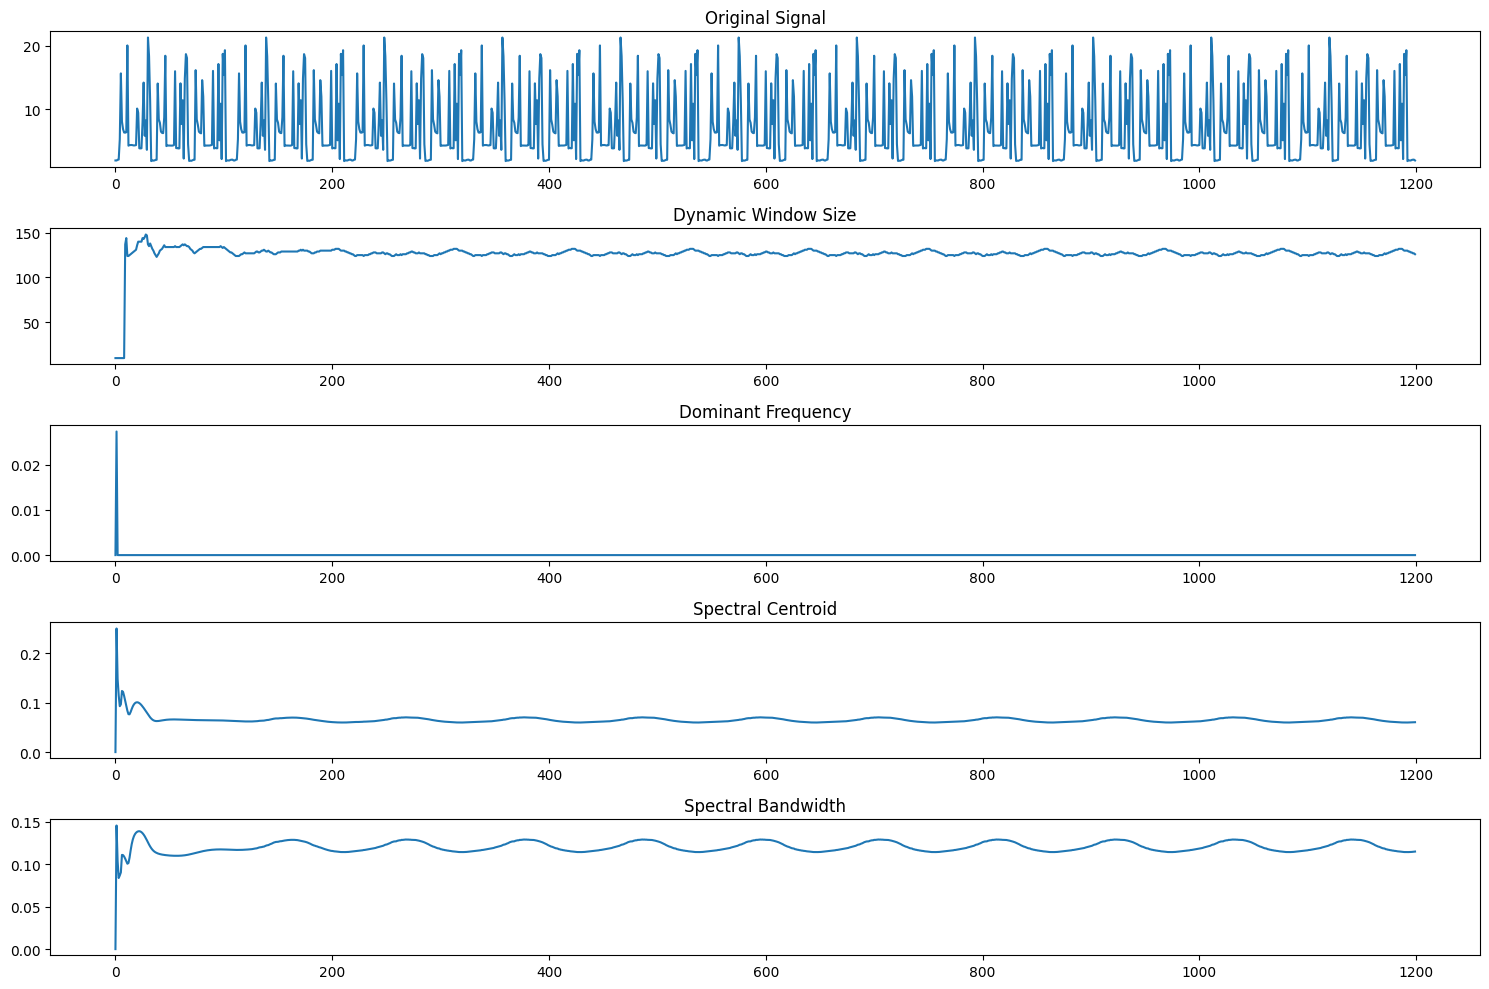


Frequency Features Summary:


,window_size,dominant_freq,dominant_freq_power,spectral_centroid,spectral_bandwidth,spectral_flatness,spectral_roll_off,spectral_crest,spectral_slope,spectral_kurtosis,spectral_skewness,low_freq_power,mid_freq_power,high_freq_power,low_high_ratio,harmonic_ratio,fundamental_freq,wavelet_energy_ratio,wavelet_entropy
0,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10,0.027344,3.575881,0.250000,0.145461,1.000000,0.425781,1.000000,6.606042e-18,NaN,NaN,0.333333,0.333333,0.333333,1.000000,0.077519,0.011719,0.000000,0.000000
2,10,0.000000,8.520561,0.147685,0.103395,0.519165,0.265625,1.998404,-1.119949e+00,-1.503905,-1.277678e-16,0.609654,0.333333,0.057013,10.693222,0.000000,0.000000,0.000388,0.005168
3,10,0.000000,15.737089,0.114587,0.083664,0.233796,0.207031,2.642956,-1.958921e+00,-1.345440,4.746063e-01,0.743995,0.243423,0.012582,59.131224,0.000000,0.000000,0.045122,0.294340
4,10,0.000000,37.451013,0.092872,0.086720,0.315201,0.156250,3.581190,-1.446299e+00,-0.605608,9.988118e-01,0.869761,0.095497,0.034742,25.035091,0.000000,0.000000,0.040556,0.244544


,window_size,dominant_freq,dominant_freq_power,spectral_centroid,spectral_bandwidth,spectral_flatness,spectral_roll_off,spectral_crest,spectral_slope,spectral_kurtosis,spectral_skewness,low_freq_power,mid_freq_power,high_freq_power,low_high_ratio,harmonic_ratio,fundamental_freq,wavelet_energy_ratio,wavelet_entropy
count,86327.000000,8.632700e+04,86327.000000,86327.000000,86327.000000,86327.000000,86327.000000,86327.000000,8.632700e+04,86326.000000,8.632600e+04,86327.000000,86327.000000,86327.000000,86327.000000,86327.000000,86327.000000,86327.000000,86327.000000
mean,126.878103,3.167462e-07,184605.180541,0.064435,0.120768,0.146478,0.191490,44.186634,-6.693621e-01,59.390813,7.620286e+00,0.839266,0.096577,0.064145,13.318560,0.011986,0.067694,0.300947,1.215679
std,2.377885,9.306465e-05,10432.689569,0.003781,0.005259,0.016820,0.008732,1.257089,7.915273e-02,1.701043,1.364870e-01,0.008428,0.001734,0.008409,1.810333,0.016852,0.028318,0.122892,0.265816
min,10.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.958921e+00,-1.503905,-1.277678e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,125.000000,0.000000e+00,176123.042381,0.061016,0.115900,0.135460,0.183594,43.672095,-7.383875e-01,58.448176,7.561501e+00,0.831388,0.095942,0.056256,11.409431,0.000000,0.058594,0.196000,0.988356
50%,127.000000,0.000000e+00,186120.082614,0.063451,0.119552,0.154239,0.195312,44.172562,-6.840832e-01,59.308036,7.615031e+00,0.841073,0.096655,0.062052,13.562291,0.008934,0.074219,0.268580,1.171093
75%,128.000000,0.000000e+00,191970.094500,0.068357,0.126299,0.158078,0.199219,44.623607,-6.036020e-01,60.405809,7.683868e+00,0.846423,0.097276,0.072923,15.058143,0.009614,0.074219,0.365310,1.394068
max,148.000000,2.734375e-02,202060.938726,0.250000,0.145461,1.000000,0.425781,46.110507,6.606042e-18,62.571915,7.815392e+00,0.869761,0.333333,0.333333,59.131224,0.077519,0.148438,0.610364,1.797719



Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86327 entries, 0 to 86326
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   window_size           86327 non-null  int64  
 1   dominant_freq         86327 non-null  float64
 2   dominant_freq_power   86327 non-null  float64
 3   spectral_centroid     86327 non-null  float64
 4   spectral_bandwidth    86327 non-null  float64
 5   spectral_flatness     86327 non-null  float64
 6   spectral_roll_off     86327 non-null  float64
 7   spectral_crest        86327 non-null  float64
 8   spectral_slope        86327 non-null  float64
 9   spectral_kurtosis     86326 non-null  float64
 10  spectral_skewness     86326 non-null  float64
 11  low_freq_power        86327 non-null  float64
 12  mid_freq_power        86327 non-null  float64
 13  high_freq_power       86327 non-null  float64
 14  low_high_ratio        86327 non-null  float64


In [56]:
def plot_freq_features(data, freq_features, n_samples=1200):
    """
    Simple function to plot frequency domain features.

    Parameters:
    - data: Original time series data (with 'Amplitude' column)
    - freq_features: DataFrame with frequency domain features
    - n_samples: Number of samples to plot (default: 1200)
    """
    import matplotlib.pyplot as plt

    # Restrict to specified number of samples
    n_samples = min(n_samples, len(freq_features))

    plt.figure(figsize=(15, 10))

    # Plot original signal if available
    if 'Amplitude' in data.columns:
        plt.subplot(5, 1, 1)
        plt.plot(data['Amplitude'].iloc[:n_samples])
        plt.title('Original Signal')

    # Plot window size
    if 'window_size' in freq_features.columns:
        plt.subplot(5, 1, 2)
        plt.plot(freq_features['window_size'].iloc[:n_samples])
        plt.title('Dynamic Window Size')

    # Plot dominant frequency
    if 'dominant_freq' in freq_features.columns:
        plt.subplot(5, 1, 3)
        plt.plot(freq_features['dominant_freq'].iloc[:n_samples])
        plt.title('Dominant Frequency')

    # Plot spectral centroid
    if 'spectral_centroid' in freq_features.columns:
        plt.subplot(5, 1, 4)
        plt.plot(freq_features['spectral_centroid'].iloc[:n_samples])
        plt.title('Spectral Centroid')

    # Plot spectral bandwidth
    if 'spectral_bandwidth' in freq_features.columns:
        plt.subplot(5, 1, 5)
        plt.plot(freq_features['spectral_bandwidth'].iloc[:n_samples])
        plt.title('Spectral Bandwidth')

    plt.tight_layout()
    plt.show()

    # Display summary statistics
    print("\nFrequency Features Summary:")
    display(freq_features.head())
    display(freq_features.describe())

    # Display basic dataframe info
    print("\nDataframe Information:")
    freq_features.info()


def plot_selected_freq_features(data, freq_features, feature_list, n_samples=1200):
    """
    Plot selected frequency domain features.

    Parameters:
    - data: Original time series data (with 'Amplitude' column)
    - freq_features: DataFrame with frequency domain features
    - feature_list: List of feature names to plot
    - n_samples: Number of samples to plot (default: 1200)
    """
    import matplotlib.pyplot as plt

    # Restrict to specified number of samples
    n_samples = min(n_samples, len(freq_features))

    # Calculate number of subplots needed
    n_plots = len(feature_list) + 1  # +1 for original signal

    plt.figure(figsize=(15, 3*n_plots))

    # Plot original signal if available
    if 'Amplitude' in data.columns:
        plt.subplot(n_plots, 1, 1)
        plt.plot(data['Amplitude'].iloc[:n_samples])
        plt.title('Original Signal')

    # Plot each selected feature
    for i, feature in enumerate(feature_list):
        if feature in freq_features.columns:
            plt.subplot(n_plots, 1, i+2)
            plt.plot(freq_features[feature].iloc[:n_samples])
            plt.title(f'{feature}')

    plt.tight_layout()
    plt.show()


# Example usage:
# 1. Default plot with typical frequency features
plot_freq_features(data, freq_features)

# 2. Plot with custom feature selection
# selected_features = ['dominant_freq', 'spectral_flatness', 'low_high_ratio', 'harmonic_ratio']
# plot_selected_freq_features(data, freq_features, selected_features)

In [57]:
##Combine the original data with the features we extracted
freq_features_df = freq_features.drop(columns=['window_size'])
data= pd.concat([data, freq_features_df], axis=1)
data.head()

,Amplitude,mean,median,std,iqr,skew,kurtosis,range,mad,energy,...,spectral_kurtosis,spectral_skewness,low_freq_power,mid_freq_power,high_freq_power,low_high_ratio,harmonic_ratio,fundamental_freq,wavelet_energy_ratio,wavelet_entropy
0,1.900,1.895500,1.8955,0.004500,0.00450,0.000000,-2.000000,0.009,0.0045,3.592941,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.891,1.930667,1.9000,0.049869,0.05500,0.689873,-1.500000,0.110,0.0090,3.729961,...,NaN,NaN,0.333333,0.333333,0.333333,1.000000,0.077519,0.011719,0.000000,0.000000
2,2.001,1.958250,1.9505,0.064403,0.11325,0.133812,-1.805527,0.150,0.0550,3.838891,...,-1.503905,-1.277678e-16,0.609654,0.333333,0.057013,10.693222,0.000000,0.000000,0.000388,0.005168
3,2.041,2.614600,2.0010,1.313963,0.14100,1.492810,0.240377,3.349,0.1010,8.562633,...,-1.345440,4.746063e-01,0.743995,0.243423,0.012582,59.131224,0.000000,0.000000,0.045122,0.294340
4,5.240,4.780833,2.0210,4.990149,2.51500,1.583550,0.767563,13.721,0.1255,47.757951,...,-0.605608,9.988118e-01,0.869761,0.095497,0.034742,25.035091,0.000000,0.000000,0.040556,0.244544


🔍 Top Features for Modeling/Visualization:

                          Variance  PCA_Importance  Mutual_Info  Average_Score
dominant_freq_power   1.000000e+00        0.606202     0.999703       0.868635
local_variation       2.989011e-12        1.000000     0.995472       0.665157
low_freq_power        5.213374e-13        0.977896     0.997273       0.658390
spectral_flatness     2.467891e-12        0.952876     0.999466       0.650781
spectral_centroid     0.000000e+00        0.947743     0.999754       0.649165
wavelet_energy_ratio  1.386260e-10        0.805230     0.995854       0.600362
skew                  3.169022e-11        0.742355     0.997759       0.580038
entropy               2.403353e-10        0.755618     0.980233       0.578617
mean                  1.324344e-10        0.733293     0.999046       0.577446
crest_factor          1.635212e-11        0.731915     0.997715       0.576543


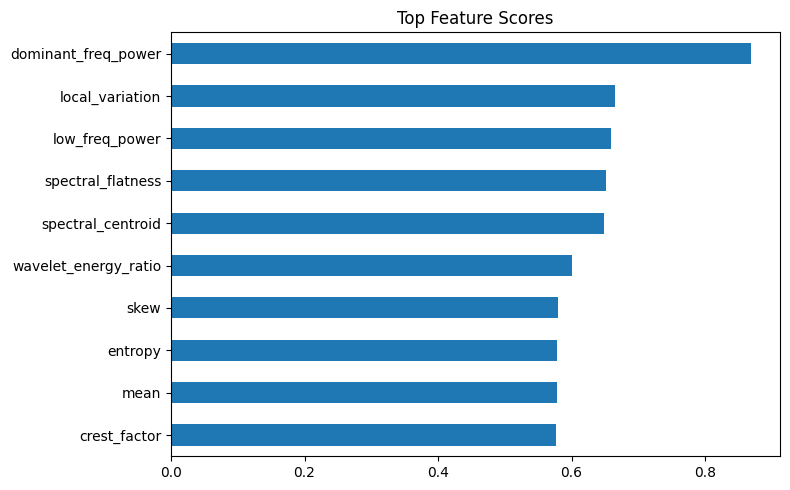

In [58]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

# Step 1: Numeric features only
X = data.select_dtypes(include='number')

# --- 1. Feature Variance ---
variance_scores = X.var()
low_variance_filter = variance_scores[variance_scores > 1e-5]
X = X[low_variance_filter.index]

# Drop highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
redundant = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=redundant)


# --- 2. impute and Scale ---

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# --- 3. Feature Importance via PCA ---

pca = PCA()
pca.fit(X_scaled)
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns)

# weight each component’s contribution
pca_importance = (pca_loadings.abs() * pca.explained_variance_ratio_).sum(axis=1)



# --- 4. Mutual Information via KMeans Pseudo-labels ---

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

mi_scores = pd.Series(mutual_info_classif(X_scaled, cluster_labels, discrete_features=False),
                      index=X.columns)

# --- 5. Combine All Scores ---

all_scores = pd.DataFrame({
    'Variance': variance_scores[X.columns],  # Recalculate for final features
    'PCA_Importance': pca_importance,
    'Mutual_Info': mi_scores
})

# Normalize all scores to 0-1
all_scores = all_scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Average Score
all_scores['Average_Score'] = all_scores.mean(axis=1)

# Sort by average score
top_features = all_scores.sort_values('Average_Score', ascending=False)

# --- 6. Display Top N Features ---

N = 10
print("🔍 Top Features for Modeling/Visualization:\n")
print(top_features.head(N))

top_features.head(N)['Average_Score'].plot(kind='barh', figsize=(8, 5), title='Top Feature Scores')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
top = top_features.head(N).index.tolist()


| Feature                                   | What it Might Represent                                                |
| ----------------------------------------- | ---------------------------------------------------------------------- |
| `dominant_freq_power`                     | Energy in dominant frequency — strong signal indicator.                |
| `local_variation`                         | Local signal change — good for detecting micro-anomalies.              |
| `low_freq_power`                          | Captures machine drift, idle-state changes.                            |
| `spectral_flatness`                       | Tonal vs. noise-like signal — distinguishes stable vs. erratic cycles. |
| `spectral_centroid`                       | Frequency balance — tracks system wear or imbalance.                   |
| `wavelet_energy_ratio`                    | Great for time-localized frequency bursts.                             |
| `skew`, `entropy`, `mean`, `crest_factor` | All are useful shape/statistical descriptors of the signal.            |


#  Create Sequences


In [59]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=data["Amplitude"][:500],
    mode='lines',
    name='Current'
))

fig.update_layout(
    title='Zoom in to observe cycle patterns',
    xaxis_title='Time Step',
    yaxis_title='Current [A]',
    hovermode='x unified'
)

fig.show()

In [60]:
def create_overlapping_sequences(data, seq_length, step):
    sequences = []
    for start in range(0, len(data) - seq_length + 1, step):
        seq = data[start:start + seq_length]
        sequences.append(seq)
    return np.array(sequences)


In [61]:
#def create_non_overlapping_sequences(data, seq_length):
#    sequences = []
#    for start in range(0, len(data) - seq_length + 1, seq_length):
#        seq = data[start:start + seq_length]
#        sequences.append(seq)
#    return np.array(sequences)


In [62]:
import joblib
data_features= data[top]
joblib.dump(data_features.columns.tolist(), 'feature_columns.pkl')
scaler = StandardScaler()
data_features = scaler.fit_transform(data_features)
data_features = pd.DataFrame(data_features, columns=top)
# Save the scaler for later use
joblib.dump(scaler, 'scaler.save')

# seq_length: length of the sequence (cycle) we observed
seq_length = 35
# step: step size to slide the window
step = 10

In [63]:
sequences = create_overlapping_sequences(data_features, seq_length, step)
#sequences = create_non_overlapping_sequences(data_features, seq_length)
print(f"Sequences shape: {sequences.shape}")

Sequences shape: (8630, 35, 10)



*   17259 sequences
*   35 timesteps per sequence
*   10 features per timestep







In [64]:
timesteps = sequences.shape[1]
features = sequences.shape[2]


In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
inputs = Input(shape=(timesteps, features))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(features, activation='relu', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = autoencoder.fit(
    sequences, sequences,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 407.6952 - val_loss: 0.7869 - learning_rate: 0.0010
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1544.1095 - val_loss: 0.7662 - learning_rate: 0.0010
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 815943.8125 - val_loss: 0.7562 - learning_rate: 0.0010
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 5903.7715 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 91267.1328 - val_loss: 1.1461 - learning_rate: 0.0010
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 12446.1084 - val_loss: 1.2627 - learning_rate: 0.0010
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.2152 - val_loss: 1.0695 - learning_rate: 0.0010
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1.1358 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 1.0299 - val_loss: 0.

In [67]:
X_pred = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - X_pred, 2), axis=(1, 2))


270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [68]:
threshold = np.percentile(mse, 95)
print(f"Anomaly threshold: {threshold}")
np.save('threshold.npy', threshold)


Anomaly threshold: 0.9857648021793147


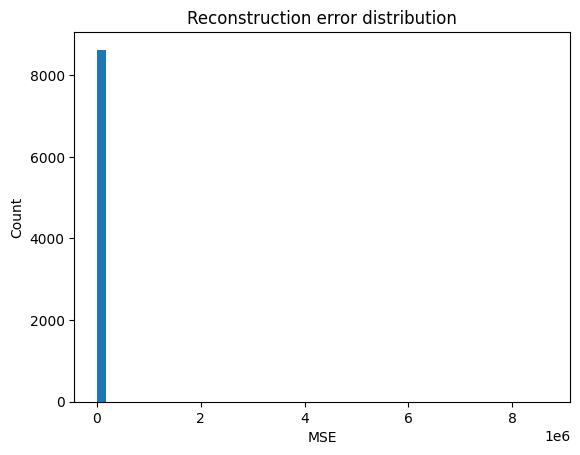

In [69]:
# --- 8. Plot reconstruction error distribution ---
plt.hist(mse, bins=50)
plt.title('Reconstruction error distribution')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.show()


In [70]:
autoencoder.save('lstm_autoencoder_model.keras')


In [71]:
df= df.rename(columns={SIGNAL_COLUMN: "Amplitude"})


In [72]:
df

,Unix timestamp [s],Date & Time,Amplitude
0,1745557328,2025-04-25 06:02:08,0.321
1,1745557334,2025-04-25 06:02:14,0.333
2,1745557340,2025-04-25 06:02:20,0.329
3,1745557346,2025-04-25 06:02:26,0.325
4,1745557352,2025-04-25 06:02:32,0.325
...,...,...,...
1803,1745568118,2025-04-25 09:01:58,7.693
1804,1745568123,2025-04-25 09:02:03,6.870
1805,1745568124,2025-04-25 09:02:04,6.867
1806,1745568130,2025-04-25 09:02:10,6.856


In [73]:
def extract_selected_features(test_data, feature_file):
    # Load selected feature names
    selected_features = joblib.load(feature_file)

    # Extract all features
    freq_features = extract_frequency_domain_features(test_data['Amplitude'], min_window=10, max_window=200)
    stat_features = extract_dynamic_window_statistical_features(test_data['Amplitude'], min_window=10, max_window=200)

    # Combine all extracted features
    all_features = pd.concat([freq_features, stat_features], axis=1)

    # Filter to keep only selected features
    selected_feature_data = all_features[selected_features]

    return selected_feature_data

In [74]:
features = extract_selected_features(df, 'feature_columns.pkl')

<ipython-input-54-030cfbe3a18d>:158: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

<ipython-input-54-030cfbe3a18d>:159: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 2 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 3 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 4 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 5 is to

In [75]:
##features_data = features_data.drop(columns=['window_size'], errors='ignore')
##feature_order = joblib.load('feature_columns.pkl')

##features = features_data[feature_order]

In [76]:
features.describe()

,dominant_freq_power,local_variation,low_freq_power,spectral_flatness,spectral_centroid,wavelet_energy_ratio,skew,entropy,mean,crest_factor
count,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000,1807.000000
mean,92762.759735,0.570025,0.845111,0.191069,0.068852,0.696457,1.642694,2.500905,4.905050,2.941855
std,90369.257056,0.216135,0.073835,0.112733,0.028996,3.103281,1.280859,0.412431,2.806776,1.199379
min,0.000000,0.098807,0.000000,0.000000,0.000000,0.000000,-5.578926,0.918296,0.210709,1.016159
25%,5488.540498,0.373165,0.808097,0.131054,0.066701,0.164388,1.138983,2.221594,2.600570,2.460767
50%,53940.229762,0.612579,0.827265,0.187387,0.075213,0.282267,1.249312,2.572712,5.717025,2.568731
75%,180392.467110,0.759810,0.847906,0.270093,0.084374,0.482757,2.071385,2.781939,7.658942,3.489628
max,266146.851955,2.000000,0.999956,1.000000,0.250000,68.491923,11.473389,3.536440,8.455108,11.599214


In [77]:
print(features.shape)

(1807, 10)


In [87]:
features = extract_selected_features(df, 'feature_columns.pkl')

# Align the original signal length with the features length
original_signal = df['Amplitude'].values[-len(features):]

<ipython-input-54-030cfbe3a18d>:158: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

<ipython-input-54-030cfbe3a18d>:159: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 2 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 3 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 4 is too high: all coefficients will experience boundary effects.

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 5 is to

In [88]:
from tensorflow.keras.models import load_model

# Load saved scaler, model, and threshold
autoencoder = load_model('lstm_autoencoder_model.keras')
threshold = np.load('threshold.npy')


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step
Anomaly threshold: 0.9857648021793147
Number of anomalous sequences: 57 / 178


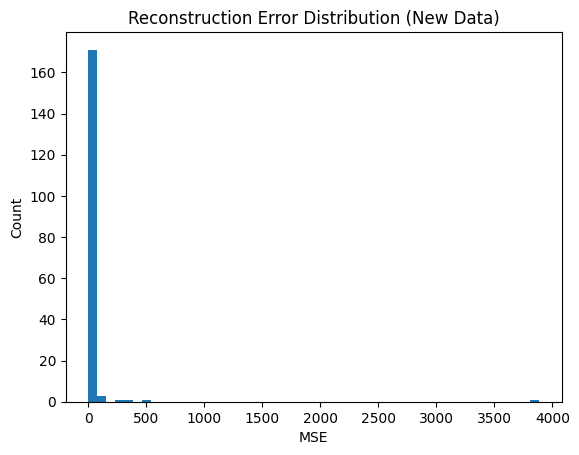

In [89]:
# Scale new data (use loaded scaler, don't fit)
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(features)
# Create overlapping sequences (same seq_length and step as training)
#def create_overlapping_sequences(data, seq_length, step):
#    sequences = []
#    for start in range(0, len(data) - seq_length + 1, step):
#        seq = data[start:start + seq_length]
#        sequences.append(seq)
#    return np.array(sequences)

#def create_non_overlapping_sequences(data, seq_length):
#    sequences = []
#    for start in range(0, len(data) - seq_length + 1, seq_length):
#        seq = data[start:start + seq_length]
#        sequences.append(seq)
#    return np.array(sequences)

seq_length = 35
step = 10
new_sequences = create_overlapping_sequences(new_data_scaled, seq_length, step)
#new_sequences = create_non_overlapping_sequences(new_data_scaled, seq_length)

# Predict reconstruction
X_pred_new = autoencoder.predict(new_sequences)

# Calculate MSE per sequence
mse_new = np.mean(np.power(new_sequences - X_pred_new, 2), axis=(1, 2))
mse_norm = (mse_new - mse_new.min()) / (mse_new.max() - mse_new.min())

print(f"Anomaly threshold: {threshold}")
# Detect anomalies based on threshold
anomalies = mse_new > threshold

print(f"Number of anomalous sequences: {np.sum(anomalies)} / {len(anomalies)}")

# Optional: plot error histogram for new data
plt.hist(mse_new, bins=50)
plt.title('Reconstruction Error Distribution (New Data)')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.show()


In [90]:
# Calculate start indices directly from how you created the sequences
start_indices = list(range(0, len(new_data_scaled) - seq_length + 1, step))
end_indices = [i + seq_length - 1 for i in start_indices]

#end_indices = start_indices + seq_length - 1
# Now confirm they all match the length of mse_new
assert len(start_indices) == len(mse_new), "Start indices and MSE length mismatch"
assert len(end_indices) == len(mse_new), "End indices and MSE length mismatch"

# Create a DataFrame of anomalies per sequence
anomaly_df = pd.DataFrame({
    'start_index': start_indices,
    'end_index': end_indices,
    'reconstruction_error': mse_new,
    'is_anomaly': anomalies
})

# Initialize a column in original features DataFrame to mark anomalies per data point
features['anomaly'] = 0

# Mark anomalies on original data points covered by anomalous sequences
for _, row in anomaly_df[anomaly_df['is_anomaly']].iterrows():
    features.loc[row['start_index']:row['end_index'], 'anomaly'] = 1

# Now `features['anomaly']` flags each data point if it belongs to an anomalous sequence
print(features['anomaly'].value_counts())


anomaly
0    1052
1     755
Name: count, dtype: int64


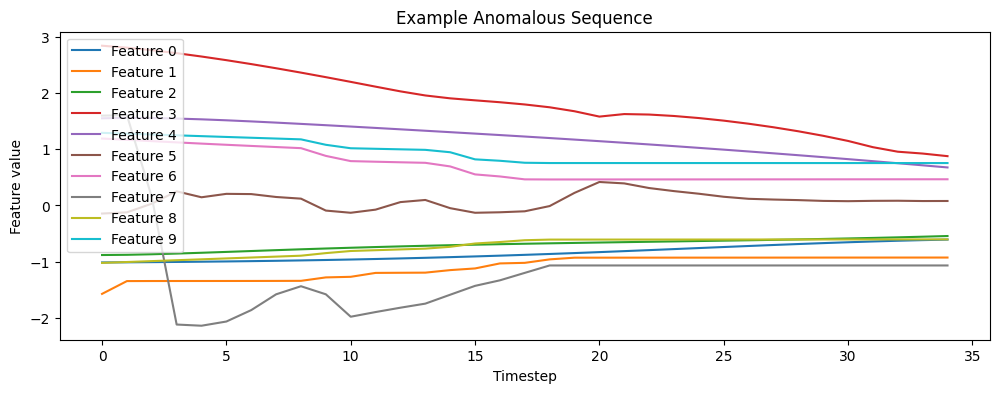

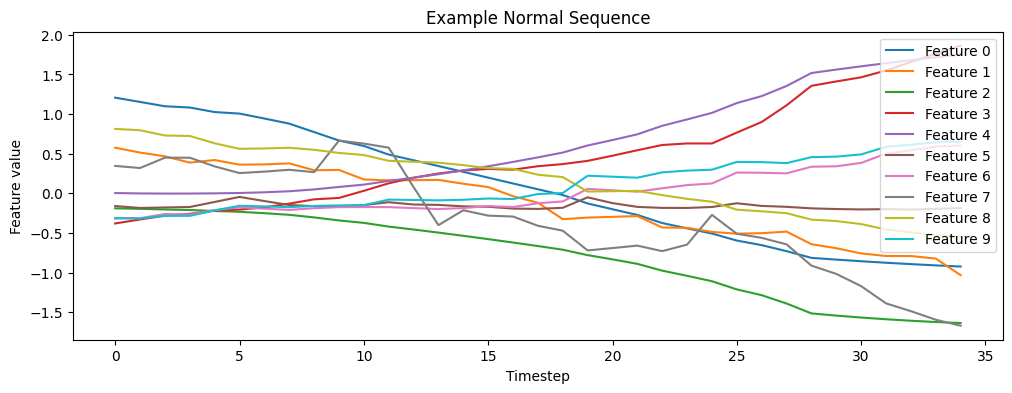

In [91]:
import matplotlib.pyplot as plt
import random

# Get indices for anomalous and normal sequences
anomaly_indices = [i for i, val in enumerate(anomalies) if val]
normal_indices = [i for i, val in enumerate(anomalies) if not val]

def plot_sequence(seq, title):
    plt.figure(figsize=(12, 4))
    for feature_idx in range(seq.shape[1]):
        plt.plot(seq[:, feature_idx], label=f'Feature {feature_idx}')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Feature value')
    plt.legend()
    plt.show()

# Pick and plot random anomalous sequence
if anomaly_indices:
    sample_anomaly_idx = random.choice(anomaly_indices)
    plot_sequence(new_sequences[sample_anomaly_idx], 'Example Anomalous Sequence')
else:
    print("⚠️ No anomalous sequences found.")

# Pick and plot random normal sequence
if normal_indices:
    sample_normal_idx = random.choice(normal_indices)
    plot_sequence(new_sequences[sample_normal_idx], 'Example Normal Sequence')
else:
    print("⚠️ No normal sequences found.")


In [92]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd


# Create masks for normal and anomalous points
normal_mask = features['anomaly'] == 0
anomaly_mask = features['anomaly'] == 1

# Create the main plot
fig = go.Figure()

# Add normal points (blue line)
normal_indices = np.where(normal_mask)[0]
fig.add_trace(go.Scatter(
    x=normal_indices,
    y=original_signal[normal_mask],
    mode='lines',
    name='Normal',
    line=dict(color='blue', width=1),
    opacity=0.7
))

# Add anomalous points (red line/markers)
anomaly_indices = np.where(anomaly_mask)[0]
if len(anomaly_indices) > 0:
    fig.add_trace(go.Scatter(
        x=anomaly_indices,
        y=original_signal[anomaly_mask],
        mode='lines+markers',
        name='Anomalies',
        line=dict(color='red', width=2),
        marker=dict(color='red', size=4),
        opacity=0.9
    ))

# Update layout
fig.update_layout(
    title='Signal with Anomaly Detection Results',
    xaxis_title='Time Index',
    yaxis_title='Amplitude',  # Change this to match your feature name
    hovermode='x unified',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

# Alternative: Scatter plot version for better anomaly visibility
fig2 = go.Figure()

# Plot all points as a line
fig2.add_trace(go.Scatter(
    x=list(range(len(original_signal))),
    y=original_signal,
    mode='lines',
    name='Signal',
    line=dict(color='lightblue', width=1),
    opacity=0.6
))

# Highlight anomalies as red markers
if len(anomaly_indices) > 0:
    fig2.add_trace(go.Scatter(
        x=anomaly_indices,
        y=original_signal[anomaly_indices],
        mode='markers',
        name='Anomalies',
        marker=dict(color='red', size=6),
        opacity=0.9
    ))

fig2.update_layout(
    title='Signal with Anomalies Highlighted',
    xaxis_title='Time Index',
    yaxis_title='Amplitude',
    hovermode='x unified',
    template='plotly_white',
    width=1200,
    height=600
)

fig2.show()

# Function to plot all features with anomalies
def plot_all_features_with_anomalies():
    feature_columns = [col for col in features.columns if col != 'anomaly']
    n_features = len(feature_columns)

    # Create subplots
    fig = make_subplots(
        rows=n_features,
        cols=1,
        subplot_titles=feature_columns,
        vertical_spacing=0.08
    )

    for i, col in enumerate(feature_columns):
        signal = features[col].values
        row = i + 1

        # Add normal points
        fig.add_trace(go.Scatter(
            x=normal_indices,
            y=signal[normal_mask],
            mode='lines',
            name=f'{col} - Normal',
            line=dict(color='blue', width=1),
            opacity=0.7,
            showlegend=(i == 0)  # Only show legend for first subplot
        ), row=row, col=1)

        # Add anomalous points
        if len(anomaly_indices) > 0:
            fig.add_trace(go.Scatter(
                x=anomaly_indices,
                y=signal[anomaly_mask],
                mode='lines+markers',
                name=f'{col} - Anomalies',
                line=dict(color='red', width=2),
                marker=dict(color='red', size=3),
                opacity=0.9,
                showlegend=(i == 0)  # Only show legend for first subplot
            ), row=row, col=1)

        # Update y-axis title for each subplot
        fig.update_yaxes(title_text=col, row=row, col=1)

    # Update layout
    fig.update_layout(
        title='All Features with Anomaly Detection Results',
        height=300 * n_features,
        hovermode='x unified',
        template='plotly_white'
    )

    # Update x-axis title for bottom subplot only
    fig.update_xaxes(title_text='Time Index', row=n_features, col=1)

    fig.show()

# Interactive version with anomaly sequences highlighted
def plot_with_sequence_info():
    fig = go.Figure()

    # Plot normal points
    fig.add_trace(go.Scatter(
        x=normal_indices,
        y=original_signal[normal_mask],
        mode='lines',
        name='Normal',
        line=dict(color='blue', width=1),
        opacity=0.7
    ))

    # Add anomalous sequences as separate traces for better hover info
    if len(anomaly_indices) > 0:
        # Group consecutive anomaly indices into sequences
        anomaly_groups = []
        current_group = [anomaly_indices[0]]

        for i in range(1, len(anomaly_indices)):
            if anomaly_indices[i] - anomaly_indices[i-1] == 1:
                current_group.append(anomaly_indices[i])
            else:
                anomaly_groups.append(current_group)
                current_group = [anomaly_indices[i]]
        anomaly_groups.append(current_group)

        # Plot each anomaly group
        for i, group in enumerate(anomaly_groups):
            fig.add_trace(go.Scatter(
                x=group,
                y=original_signal[group],
                mode='lines+markers',
                name=f'Anomaly Sequence {i+1}',
                line=dict(color='red', width=2),
                marker=dict(color='red', size=4),
                opacity=0.9,
                customdata=[f'Sequence {i+1}: Points {group[0]}-{group[-1]}'] * len(group),
                hovertemplate='<b>%{customdata}</b><br>Index: %{x}<br>Value: %{y:.4f}<extra></extra>'
            ))

    fig.update_layout(
        title='Signal with Anomaly Sequences',
        xaxis_title='Time Index',
        yaxis_title='Amplitude',
        hovermode='closest',
        template='plotly_white',
        width=1200,
        height=600
    )

    fig.show()

# Print statistics
print(f"Total data points: {len(original_signal)}")
print(f"Anomalous points: {sum(anomaly_mask)}")
print(f"Percentage anomalous: {100 * sum(anomaly_mask) / len(original_signal):.2f}%")
print(f"Number of anomaly sequences detected: {len(anomaly_df[anomaly_df['is_anomaly']])}")

# Uncomment to show all features:
# plot_all_features_with_anomalies()

# Uncomment to show interactive version with sequence info:
# plot_with_sequence_info()

Total data points: 1807
Anomalous points: 755
Percentage anomalous: 41.78%
Number of anomaly sequences detected: 57


In [93]:
# Check split
normal_indices = [i for i, val in enumerate(anomalies) if not val]
anomaly_indices = [i for i, val in enumerate(anomalies) if val]

print(f"Normal: {len(normal_indices)}  |  Anomalies: {len(anomaly_indices)}")

if len(normal_indices) == 0:
    print("⚠️ Still no normal sequences found — try lowering threshold percentile (e.g., 99 → 98).")


Normal: 121  |  Anomalies: 57


In [94]:
# Flag each point in the original signal if it belongs to an anomalous sequence
anomaly_flags = np.zeros(len(features), dtype=bool)

for idx, is_anomaly in zip(end_indices, anomalies):
    if is_anomaly:
        anomaly_flags[idx - seq_length + 1 : idx + 1] = True  # flag the full sequence


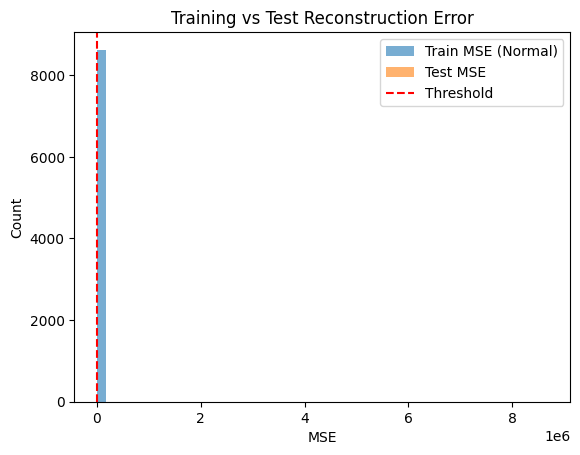

In [95]:
plt.hist(mse, bins=50, alpha=0.6, label='Train MSE (Normal)')
plt.hist(mse_new, bins=50, alpha=0.6, label='Test MSE')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('Training vs Test Reconstruction Error')
plt.legend()
plt.show()


In [96]:
print("Training sequences stats:")
print("Min:", sequences.min(), "Max:", sequences.max(), "Mean:", sequences.mean(), "Std:", sequences.std())

print("Test sequences stats:")
print("Min:", new_sequences.min(), "Max:", new_sequences.max(), "Mean:", new_sequences.mean(), "Std:", new_sequences.std())


Training sequences stats:
Min: -99.57832699979805 Max: 69.62263231833265 Mean: 0.00037027512988795357 Std: 0.9780843474142177
Test sequences stats:
Min: -11.449057344748962 Max: 21.852433946755443 Mean: 0.0011873696911410432 Std: 0.9870748450998247


In [97]:
print("Test sequences stats (after fix):")
print("Min:", new_data_scaled.min(), "Max:", new_data_scaled.max(), "Mean:", new_data_scaled.mean(), "Std:", new_data_scaled.std())


Test sequences stats (after fix):
Min: -11.449057344748962 Max: 21.852433946755443 Mean: 1.1953790352577225e-16 Std: 1.0


In [98]:
# --- CONFIG ---
CSV_FILE = "KNC2.csv"
SIGNAL_COLUMN = "KNC 200 [A]"
TIME_COLUMN = "Unix timestamp [s]"
DATETIME_COLUMN = "Date & Time"
MINIMUM_DISTANCE = 10  # Minimum distance between peaks in samples
THRESHOLD_METHOD = "std"  # Choose: "std", "percentile", "baseline"
FACTOR = 2.0      # For std method
PERCENTILE = 95   # For percentile method
DELTA = 1.5       # For baseline method


In [99]:
## Upload the file
import numpy as np
import pandas as pd
import plotly.graph_objs as go

df = pd.read_csv(CSV_FILE)

##Vizualise the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[DATETIME_COLUMN], y=df[SIGNAL_COLUMN]))
fig.update_layout(
    title="Original Signal (Zoomable)",
    xaxis_title="Date & Time",
    yaxis_title="Current [A]",
    template="plotly_white",
    height=500
)

fig.show()


In [100]:
## Choose the data from 4/9/2025 5:40:10PM to 4/9/2025 5:57:44PM
# Convert 'Date & Time' column to datetime objects
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format='%m/%d/%Y %I:%M:%S%p')

# Filter the data
df_segment = df[(df['Date & Time'] >= pd.to_datetime('2024-09-04 17:39:40')) &
                (df['Date & Time'] <= pd.to_datetime('2024-09-04 17:57:50'))]

# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_segment[DATETIME_COLUMN], y=df_segment[SIGNAL_COLUMN]))
fig.update_layout(
    title="Chosen Segment (Zoomable)",
    xaxis_title="Date & Time",
    yaxis_title="Current [A]",
    template="plotly_white",
    height=500
)
fig.show()
print(f"Filtered segment size: {df_segment.shape}")
print(df['Date & Time'].head())



Filtered segment size: (1091, 3)
0   2024-09-04 17:37:35
1   2024-09-04 17:37:36
2   2024-09-04 17:37:37
3   2024-09-04 17:37:38
4   2024-09-04 17:37:39
Name: Date & Time, dtype: datetime64[ns]


In [101]:
## Create a data set with duplication of the segment for almost 24hours
segment_duration = df_segment['Date & Time'].iloc[-1] - df_segment['Date & Time'].iloc[0]
print(f"Segment duration: {segment_duration}")


Segment duration: 0 days 00:18:10


In [102]:
import numpy as np

target_duration = pd.Timedelta(hours=24)
repeat_count = int(np.floor(target_duration / segment_duration))
print(f"Repeat count: {repeat_count}")


Repeat count: 79


In [103]:
df_duplicated = pd.concat([df_segment] * repeat_count, ignore_index=True)


In [104]:
df_duplicated

,Unix timestamp [s],Date & Time,KNC 200 [A]
0,1725467980,2024-09-04 17:39:40,4.267
1,1725467981,2024-09-04 17:39:41,4.266
2,1725467982,2024-09-04 17:39:42,4.276
3,1725467983,2024-09-04 17:39:43,4.892
4,1725467984,2024-09-04 17:39:44,5.347
...,...,...,...
86184,1725469066,2024-09-04 17:57:46,5.112
86185,1725469067,2024-09-04 17:57:47,5.329
86186,1725469068,2024-09-04 17:57:48,6.184
86187,1725469069,2024-09-04 17:57:49,5.269


In [105]:
## Remove the unix timestamp and date and time columns and rename the Nakamura 2 [A] column to Amplitude
data = df_duplicated.drop(columns=[TIME_COLUMN, DATETIME_COLUMN])
data = data.rename(columns={SIGNAL_COLUMN: "Amplitude"})
## Information about the dataframe
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86189 entries, 0 to 86188
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Amplitude  86189 non-null  float64
dtypes: float64(1)
memory usage: 673.5 KB


,Amplitude
count,86189.000000
mean,9.104457
std,4.288800
min,4.265000
25%,8.158000
50%,8.556000
75%,9.122000
max,33.823000


In [ ]:
statistical_features = extract_dynamic_window_statistical_features(data['Amplitude'], min_window=10, max_window=200)


In [ ]:
import matplotlib.pyplot as plt

# Plot example features
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(data['Amplitude'].iloc[:1200])
plt.title('Original Signal')

plt.subplot(4, 1, 2)
plt.plot(statistical_features['window_size'].iloc[:1200])
plt.title('Dynamic Window Size')

plt.subplot(4, 1, 3)
plt.plot(statistical_features['mean'].iloc[:1200])
plt.title('Mean (with dynamic window)')

plt.subplot(4, 1, 4)
plt.plot(statistical_features['std'].iloc[:1200])
plt.title('Standard Deviation (with dynamic window)')

plt.tight_layout()
plt.show()
statistical_features.head()
statistical_features.describe()
statistical_features.info()

In [ ]:
##Combine the original data with the features we extracted
features_df = statistical_features.drop(columns=['window_size'])
data= pd.concat([data, features_df], axis=1)
data.head()

In [ ]:
freq_features = extract_frequency_domain_features(data['Amplitude'], min_window=10, max_window=200)


In [ ]:
import matplotlib.pyplot as plt

# Plot example features
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(data['Amplitude'].iloc[:1200])
plt.title('Original Signal')

plt.subplot(4, 1, 2)
plt.plot(statistical_features['window_size'].iloc[:1200])
plt.title('Dynamic Window Size')

plt.subplot(4, 1, 3)
plt.plot(statistical_features['mean'].iloc[:1200])
plt.title('Mean (with dynamic window)')

plt.subplot(4, 1, 4)
plt.plot(statistical_features['std'].iloc[:1200])
plt.title('Standard Deviation (with dynamic window)')

plt.tight_layout()
plt.show()
statistical_features.head()
statistical_features.describe()
statistical_features.info()

In [ ]:
##Combine the original data with the features we extracted
freq_features_df = freq_features.drop(columns=['window_size'])
data= pd.concat([data, freq_features_df], axis=1)
data.head()

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

# Step 1: Numeric features only
X = data.select_dtypes(include='number')

# --- 1. Feature Variance ---
variance_scores = X.var()
low_variance_filter = variance_scores[variance_scores > 1e-5]
X = X[low_variance_filter.index]

# Drop highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
redundant = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=redundant)


# --- 2. impute and Scale ---

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# --- 3. Feature Importance via PCA ---

pca = PCA()
pca.fit(X_scaled)
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns)

# weight each component’s contribution
pca_importance = (pca_loadings.abs() * pca.explained_variance_ratio_).sum(axis=1)



# --- 4. Mutual Information via KMeans Pseudo-labels ---

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

mi_scores = pd.Series(mutual_info_classif(X_scaled, cluster_labels, discrete_features=False),
                      index=X.columns)

# --- 5. Combine All Scores ---

all_scores = pd.DataFrame({
    'Variance': variance_scores[X.columns],  # Recalculate for final features
    'PCA_Importance': pca_importance,
    'Mutual_Info': mi_scores
})

# Normalize all scores to 0-1
all_scores = all_scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Average Score
all_scores['Average_Score'] = all_scores.mean(axis=1)

# Sort by average score
top_features = all_scores.sort_values('Average_Score', ascending=False)

# --- 6. Display Top N Features ---

N = 10
print("🔍 Top Features for Modeling/Visualization:\n")
print(top_features.head(N))

top_features.head(N)['Average_Score'].plot(kind='barh', figsize=(8, 5), title='Top Feature Scores')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
top = top_features.head(N).index.tolist()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=data["Amplitude"][:500],
    mode='lines',
    name='Current'
))

fig.update_layout(
    title='Zoom in to observe cycle patterns',
    xaxis_title='Time Step',
    yaxis_title='Current [A]',
    hovermode='x unified'
)

fig.show()

In [ ]:
import joblib
data_features= data[top]
joblib.dump(data_features.columns.tolist(), 'feature_columns_KNC.pkl')
scaler = StandardScaler()
data_features = scaler.fit_transform(data_features)
data_features = pd.DataFrame(data_features, columns=top)
# Save the scaler for later use
joblib.dump(scaler, 'scaler.save')

# seq_length: length of the sequence (cycle) we observed
seq_length = 100
# step: step size to slide the window
step = 20

In [ ]:
sequences = create_overlapping_sequences(data_features, seq_length, step)
#sequences = create_non_overlapping_sequences(data_features, seq_length)
print(f"Sequences shape: {sequences.shape}")

In [ ]:
timesteps = sequences.shape[1]
features = sequences.shape[2]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
inputs = Input(shape=(timesteps, features))
encoded = LSTM(128, return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(features, return_sequences=True)(decoded)


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = autoencoder.fit(
    sequences, sequences,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop, reduce_lr]
)


In [ ]:
X_pred = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - X_pred, 2), axis=(1, 2))


In [ ]:
threshold = np.percentile(mse, 98)
print(f"Anomaly threshold: {threshold}")
np.save('threshold_KNC.npy', threshold)


In [ ]:
# --- 8. Plot reconstruction error distribution ---
plt.hist(mse, bins=50)
plt.title('Reconstruction error distribution')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.show()


In [ ]:
autoencoder.save('lstm_autoencoder_model_KNC.keras')


In [ ]:
df= df.rename(columns={SIGNAL_COLUMN: "Amplitude"})


In [ ]:
features = extract_selected_features(df, 'feature_columns_KNC.pkl')

# Align the original signal length with the features length
original_signal = df['Amplitude'].values[-len(features):]

In [ ]:
from tensorflow.keras.models import load_model

# Load saved scaler, model, and threshold
autoencoder = load_model('lstm_autoencoder_model_KNC.keras')
threshold = np.load('threshold_KNC.npy')


In [ ]:
# Scale new data (use loaded scaler, don't fit)
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(features)
# Create overlapping sequences (same seq_length and step as training)
#def create_overlapping_sequences(data, seq_length, step):
#    sequences = []
#    for start in range(0, len(data) - seq_length + 1, step):
#        seq = data[start:start + seq_length]
#        sequences.append(seq)
#    return np.array(sequences)

#def create_non_overlapping_sequences(data, seq_length):
#    sequences = []
#    for start in range(0, len(data) - seq_length + 1, seq_length):
#        seq = data[start:start + seq_length]
#        sequences.append(seq)
#    return np.array(sequences)

seq_length = 100
step = 20
new_sequences = create_overlapping_sequences(new_data_scaled, seq_length, step)
#new_sequences = create_non_overlapping_sequences(new_data_scaled, seq_length)

# Predict reconstruction
X_pred_new = autoencoder.predict(new_sequences)

# Calculate MSE per sequence
mse_new = np.mean(np.power(new_sequences - X_pred_new, 2), axis=(1, 2))
mse_norm = (mse_new - mse_new.min()) / (mse_new.max() - mse_new.min())

print(f"Anomaly threshold: {threshold}")
# Detect anomalies based on threshold
anomalies = mse_new > threshold

print(f"Number of anomalous sequences: {np.sum(anomalies)} / {len(anomalies)}")

# Optional: plot error histogram for new data
plt.hist(mse_new, bins=50)
plt.title('Reconstruction Error Distribution (New Data)')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.show()


In [ ]:
# Calculate start indices directly from how you created the sequences
start_indices = list(range(0, len(new_data_scaled) - seq_length + 1, step))
end_indices = [i + seq_length - 1 for i in start_indices]

#end_indices = start_indices + seq_length - 1
# Now confirm they all match the length of mse_new
assert len(start_indices) == len(mse_new), "Start indices and MSE length mismatch"
assert len(end_indices) == len(mse_new), "End indices and MSE length mismatch"

# Create a DataFrame of anomalies per sequence
anomaly_df = pd.DataFrame({
    'start_index': start_indices,
    'end_index': end_indices,
    'reconstruction_error': mse_new,
    'is_anomaly': anomalies
})

# Initialize a column in original features DataFrame to mark anomalies per data point
features['anomaly'] = 0

# Mark anomalies on original data points covered by anomalous sequences
for _, row in anomaly_df[anomaly_df['is_anomaly']].iterrows():
    features.loc[row['start_index']:row['end_index'], 'anomaly'] = 1

# Now `features['anomaly']` flags each data point if it belongs to an anomalous sequence
print(features['anomaly'].value_counts())


In [ ]:
import matplotlib.pyplot as plt
import random

# Get indices for anomalous and normal sequences
anomaly_indices = [i for i, val in enumerate(anomalies) if val]
normal_indices = [i for i, val in enumerate(anomalies) if not val]

def plot_sequence(seq, title):
    plt.figure(figsize=(12, 4))
    for feature_idx in range(seq.shape[1]):
        plt.plot(seq[:, feature_idx], label=f'Feature {feature_idx}')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Feature value')
    plt.legend()
    plt.show()

# Pick and plot random anomalous sequence
if anomaly_indices:
    sample_anomaly_idx = random.choice(anomaly_indices)
    plot_sequence(new_sequences[sample_anomaly_idx], 'Example Anomalous Sequence')
else:
    print("⚠️ No anomalous sequences found.")

# Pick and plot random normal sequence
if normal_indices:
    sample_normal_idx = random.choice(normal_indices)
    plot_sequence(new_sequences[sample_normal_idx], 'Example Normal Sequence')
else:
    print("⚠️ No normal sequences found.")


In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd


# Create masks for normal and anomalous points
normal_mask = features['anomaly'] == 0
anomaly_mask = features['anomaly'] == 1

# Create the main plot
fig = go.Figure()

# Add normal points (blue line)
normal_indices = np.where(normal_mask)[0]
fig.add_trace(go.Scatter(
    x=normal_indices,
    y=original_signal[normal_mask],
    mode='lines',
    name='Normal',
    line=dict(color='blue', width=1),
    opacity=0.7
))

# Add anomalous points (red line/markers)
anomaly_indices = np.where(anomaly_mask)[0]
if len(anomaly_indices) > 0:
    fig.add_trace(go.Scatter(
        x=anomaly_indices,
        y=original_signal[anomaly_mask],
        mode='lines+markers',
        name='Anomalies',
        line=dict(color='red', width=2),
        marker=dict(color='red', size=4),
        opacity=0.9
    ))

# Update layout
fig.update_layout(
    title='Signal with Anomaly Detection Results',
    xaxis_title='Time Index',
    yaxis_title='Amplitude',  # Change this to match your feature name
    hovermode='x unified',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

# Alternative: Scatter plot version for better anomaly visibility
fig2 = go.Figure()

# Plot all points as a line
fig2.add_trace(go.Scatter(
    x=list(range(len(original_signal))),
    y=original_signal,
    mode='lines',
    name='Signal',
    line=dict(color='lightblue', width=1),
    opacity=0.6
))

# Highlight anomalies as red markers
if len(anomaly_indices) > 0:
    fig2.add_trace(go.Scatter(
        x=anomaly_indices,
        y=original_signal[anomaly_indices],
        mode='markers',
        name='Anomalies',
        marker=dict(color='red', size=6),
        opacity=0.9
    ))

fig2.update_layout(
    title='Signal with Anomalies Highlighted',
    xaxis_title='Time Index',
    yaxis_title='Amplitude',
    hovermode='x unified',
    template='plotly_white',
    width=1200,
    height=600
)

fig2.show()

# Function to plot all features with anomalies
def plot_all_features_with_anomalies():
    feature_columns = [col for col in features.columns if col != 'anomaly']
    n_features = len(feature_columns)

    # Create subplots
    fig = make_subplots(
        rows=n_features,
        cols=1,
        subplot_titles=feature_columns,
        vertical_spacing=0.08
    )

    for i, col in enumerate(feature_columns):
        signal = features[col].values
        row = i + 1

        # Add normal points
        fig.add_trace(go.Scatter(
            x=normal_indices,
            y=signal[normal_mask],
            mode='lines',
            name=f'{col} - Normal',
            line=dict(color='blue', width=1),
            opacity=0.7,
            showlegend=(i == 0)  # Only show legend for first subplot
        ), row=row, col=1)

        # Add anomalous points
        if len(anomaly_indices) > 0:
            fig.add_trace(go.Scatter(
                x=anomaly_indices,
                y=signal[anomaly_mask],
                mode='lines+markers',
                name=f'{col} - Anomalies',
                line=dict(color='red', width=2),
                marker=dict(color='red', size=3),
                opacity=0.9,
                showlegend=(i == 0)  # Only show legend for first subplot
            ), row=row, col=1)

        # Update y-axis title for each subplot
        fig.update_yaxes(title_text=col, row=row, col=1)

    # Update layout
    fig.update_layout(
        title='All Features with Anomaly Detection Results',
        height=300 * n_features,
        hovermode='x unified',
        template='plotly_white'
    )

    # Update x-axis title for bottom subplot only
    fig.update_xaxes(title_text='Time Index', row=n_features, col=1)

    fig.show()

# Interactive version with anomaly sequences highlighted
def plot_with_sequence_info():
    fig = go.Figure()

    # Plot normal points
    fig.add_trace(go.Scatter(
        x=normal_indices,
        y=original_signal[normal_mask],
        mode='lines',
        name='Normal',
        line=dict(color='blue', width=1),
        opacity=0.7
    ))

    # Add anomalous sequences as separate traces for better hover info
    if len(anomaly_indices) > 0:
        # Group consecutive anomaly indices into sequences
        anomaly_groups = []
        current_group = [anomaly_indices[0]]

        for i in range(1, len(anomaly_indices)):
            if anomaly_indices[i] - anomaly_indices[i-1] == 1:
                current_group.append(anomaly_indices[i])
            else:
                anomaly_groups.append(current_group)
                current_group = [anomaly_indices[i]]
        anomaly_groups.append(current_group)

        # Plot each anomaly group
        for i, group in enumerate(anomaly_groups):
            fig.add_trace(go.Scatter(
                x=group,
                y=original_signal[group],
                mode='lines+markers',
                name=f'Anomaly Sequence {i+1}',
                line=dict(color='red', width=2),
                marker=dict(color='red', size=4),
                opacity=0.9,
                customdata=[f'Sequence {i+1}: Points {group[0]}-{group[-1]}'] * len(group),
                hovertemplate='<b>%{customdata}</b><br>Index: %{x}<br>Value: %{y:.4f}<extra></extra>'
            ))

    fig.update_layout(
        title='Signal with Anomaly Sequences',
        xaxis_title='Time Index',
        yaxis_title='Amplitude',
        hovermode='closest',
        template='plotly_white',
        width=1200,
        height=600
    )

    fig.show()

# Print statistics
print(f"Total data points: {len(original_signal)}")
print(f"Anomalous points: {sum(anomaly_mask)}")
print(f"Percentage anomalous: {100 * sum(anomaly_mask) / len(original_signal):.2f}%")
print(f"Number of anomaly sequences detected: {len(anomaly_df[anomaly_df['is_anomaly']])}")

# Uncomment to show all features:
# plot_all_features_with_anomalies()

# Uncomment to show interactive version with sequence info:
# plot_with_sequence_info()

In [ ]:
print("Training sequences stats:")
print("Min:", sequences.min(), "Max:", sequences.max(), "Mean:", sequences.mean(), "Std:", sequences.std())

print("Test sequences stats:")
print("Min:", new_sequences.min(), "Max:", new_sequences.max(), "Mean:", new_sequences.mean(), "Std:", new_sequences.std())
